### QED-C Application-Oriented Benchmarks - Analyze Observable Methods

The notebook implements a procedure for analyzing different methods for computing observables.
Given a specific problem size (number of qubits), a Hamiltonian, an aboservable method (group_method), and a given total shot count, generate a specified number of random input states, and measure the resulting expectation value, both exactly and computed using the quantum expactation algorithm.

Results are plotted and the difference between the exact expectation value at each random input and the computed value is highlighted.

DEVNOTE: Much of the code in this notebook will be re-factored into other modules, as this work evolves.


### Program Configuration

In [ ]:
# Select the API to use and load the benchmark program
api = "qiskit"
from hamlib import hamlib_simulation_benchmark

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 12
skip_qubits = 1
max_circuits = 1
num_shots = 4000

# Set number of Trotter steps K and total time t
K = 0
t = 0.001

# Number of iterations performed with random initialization
iterations = 2

use_diag_method = True
group_method = "N"

# use an ansatz to generate random states; default is to use integer initialization
use_ansatz_initial_state = True

# method to use for weighted shot distribution: max_sq, mean_sq, or max
wsd_methods = ["max", "max_sq", "mean", "mean_sq"]

# Select the backend 
#backend_id = "qasm_simulator"
backend_id = "statevector_simulator"
provider_backend = None
exec_options = {}

#############

# place resulting data and images into a folder with "paper" suffix
from _common import metrics
metrics.data_suffix = "_analysis"
hamlib_simulation_benchmark.data_suffix = "_analysis"

hamlib_simulation_benchmark.max_qubits_exact = 16

skip_execution = False


In [ ]:
import numpy as np
import time
import os

from _common.qiskit import execute

# Import HamLib helper functions (from _common)
from hamlib._common import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
from hamlib.qiskit import hamlib_simulation_kernel

# Import Observable helper functions
from hamlib._common import observables
from hamlib._common import evolution_exact

#########  Configure a QASM simulator, possibly noisy
backend_id = "qasm_simulator"
exec_options = {}

# Custom optimization options can be specified in this cell (below is an example)

# # Define a custom noise model to be used during execution
import _common.custom.custom_qiskit_noise_model as custom_qiskit_noise_model

# noisy, QV = 32 ...
#exec_options.update({ "noise_model": custom_qiskit_noise_model.my_noise_model() })

#ideal ...
#exec_options.update({ "noise_model": None })

# set up the execution target
execute.set_execution_target(backend_id, exec_options=exec_options)

# object used to store metrics
from hamlib._common.new_functions import metrics_object



### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation

# DEVNOTE: this notebook does not currently use the last field of the items in this array

hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/B2', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/NH', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/CH', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ]


---
## Custom Functions used in this Notebook

### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

DEVNOTE: this analysis does not currently use the ansatz, but it will later.


In [4]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit


### Generate Random Initialization States
Here we generate initialization states using a bitstring containing 0s and 1s only.

In [ ]:
import random
from hamlib._common.result_generation_functions import generate_random_int_and_bitstring

### Custom Observable Estimation Function
This function wraps the four steps of the process into a single function.

In [ ]:
from hamlib._common.new_functions import create_measurement_circuts, do_execute, compute_energy
from hamlib._common.new_functions import compute_exact_value
from hamlib._common.result_generation_functions import estimate_expectation_value_top

### Generate N Random Input States and Collect Data about Computation of Observable (Energy)


---
## Observable Estimation Loop for Analysis
Here we compute an observable (energy) for the given Hamiltonian, sweeping over the specified set of group methods.  Using the value and timing analysis plots, this provides a means to compare the behavior of these methods.

In [ ]:
from qiskit_aer import Aer
from hamlib._common.result_generation_functions import prepare_random_initial_state, do_random_state_loop

## TFIM

In [8]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[0]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h-2
... number of terms in Hamiltonian = 24



done

Perform Observable Computation for: condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 24, number of groups created = 2

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

... Pauli Term Groups:
---N----
---no weight shot distribution---

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.24927868293265987
mean: -0.15987376904234796
---N:wsd----
---wsd method: max---

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.04659029752955379
mean: 0.07721004437444834
---wsd method: max_sq---

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.13710635779288227
mean: 0.046487515598272355
---wsd method: mean---

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.0983957123253224
mean: -

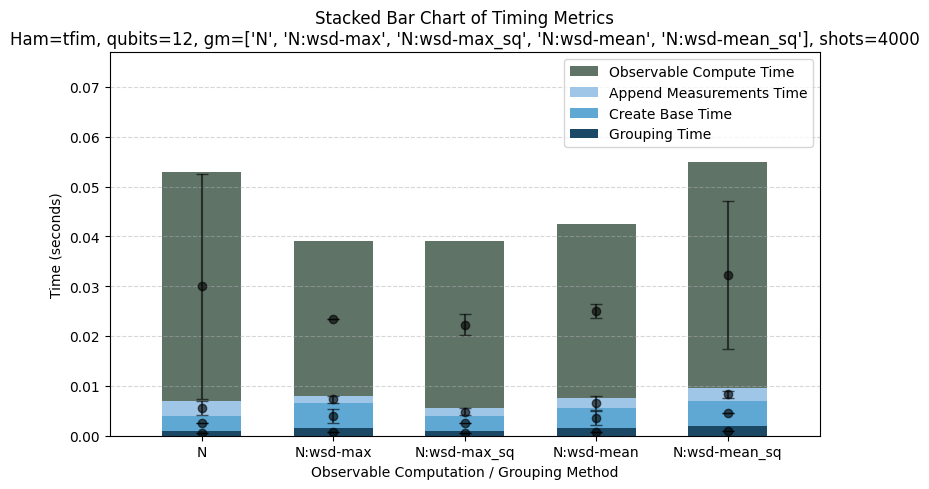

----final errors----
N: 0.249
N:wsd-max: 0.047
N:wsd-max_sq: 0.137
N:wsd-mean: 0.098
N:wsd-mean_sq: 0.052
----final means----
N: -0.160
N:wsd-max: 0.077
N:wsd-max_sq: 0.046
N:wsd-mean: -0.177
N:wsd-mean_sq: -0.054


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

group_method_list = [ "N", "N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    if distribute_shots is True:
        for wsd_method in wsd_methods:
            print(f'---wsd method: {wsd_method}---')
    
            init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots, wsd_method,
                                                                                         backend_id)

            # Generate the value anlysis plots
            std_error, mean = get_errors(
                        hamiltonian_name,
                        backend_id,
                        num_qubits,
                        group_method_label,
                        num_shots,
                        exact_energies,
                        computed_energies
                    )
            print('error:', std_error)
            print('mean:', mean)
        
        
            # Compute statistics for the collected metrics
            stats_result = compute_timing_stats(metrics_array)
            #print(stats_result)
            
            timing_datasets.append(stats_result)
            timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{wsd_method}" })
            final_errors[f"{group_method_label}-{wsd_method}"] = std_error
            final_means[f"{group_method_label}-{wsd_method}"] = mean
    else:
        print('---no weight shot distribution---')
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
        final_errors[f"{group_method_label}"] = std_error
        final_means[f"{group_method_label}"] = mean
        
        
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = ['N']
for wsd in wsd_methods:
    group_method_labels.append(f'N:wsd-{wsd}')
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

## Heisenburg model

In [10]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[1]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h-2
... number of terms in Hamiltonian = 48



done

Perform Observable Computation for: condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 48, number of groups created = 3

... Number of terms in Hamiltonian: 48
... Number of groups created: 3

... Pauli Term Groups:
---N----
---no weight shot distribution---

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.2292601017862549
mean: 0.2634318658248197
---N:wsd----
---wsd method: max---

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.018649224999838898
mean: 0.07827330076195405
---wsd method: max_sq---

..
✅ No significant bias detected.
error: 0.11392193997062541
mean: -0.0031382824009426324
---wsd method: mean---

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.03771530947327659
mean: 0.14499467046055617
---wsd method: m

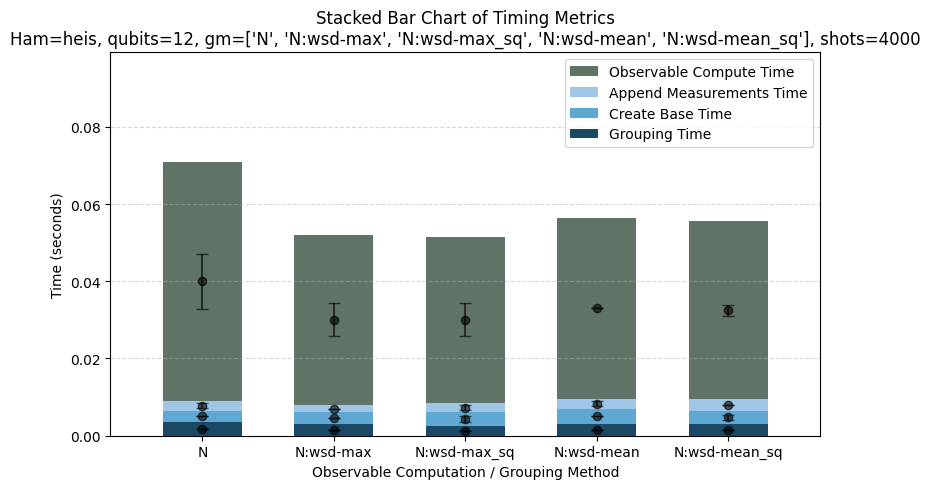

----final errors----
N: 0.229
N:wsd-max: 0.019
N:wsd-max_sq: 0.114
N:wsd-mean: 0.038
N:wsd-mean_sq: 0.260
----final means----
N: 0.263
N:wsd-max: 0.078
N:wsd-max_sq: -0.003
N:wsd-mean: 0.145
N:wsd-mean_sq: -0.118


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

group_method_list = [ "N", "N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    if distribute_shots is True:
        for wsd_method in wsd_methods:
            print(f'---wsd method: {wsd_method}---')
    
            init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots, wsd_method,
                                                                                         backend_id)

            # Generate the value anlysis plots
            std_error, mean = get_errors(
                        hamiltonian_name,
                        backend_id,
                        num_qubits,
                        group_method_label,
                        num_shots,
                        exact_energies,
                        computed_energies
                    )
            print('error:', std_error)
            print('mean:', mean)
        
        
            # Compute statistics for the collected metrics
            stats_result = compute_timing_stats(metrics_array)
            #print(stats_result)
            
            timing_datasets.append(stats_result)
            timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{wsd_method}" })
            final_errors[f"{group_method_label}-{wsd_method}"] = std_error
            final_means[f"{group_method_label}-{wsd_method}"] = mean
    else:
        print('---no weight shot distribution---')
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
        final_errors[f"{group_method_label}"] = std_error
        final_means[f"{group_method_label}"] = mean
        
        
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = ['N']
for wsd in wsd_methods:
    group_method_labels.append(f'N:wsd-{wsd}')
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [12]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[2]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/fermihubbard/FH_D-1 {'1D-grid': 'pbc', 'enc': 'bk', 'U': 12}


... dataset_name = fh-graph-1D-grid-pbc-qubitnodes_Lx-6_U-12_enc-bk
... number of terms in Hamiltonian = 43



done

Perform Observable Computation for: condensedmatter/fermihubbard/FH_D-1 {'1D-grid': 'pbc', 'enc': 'bk', 'U': 12}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 43, number of groups created = 4

... Number of terms in Hamiltonian: 43
... Number of groups created: 4

... Pauli Term Groups:
---N----
---no weight shot distribution---

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.35977095136679615
mean: -0.23173930358021444
---N:wsd----
---wsd method: max---

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.39506623044609235
mean: -0.13272531546188837
---wsd method: max_sq---

..
✅ No significant bias detected.
error: 0.09239248202914752
mean: 0.009259531512491037
---wsd method: mean---

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.09172602951342945
mean: 0.193778264181949

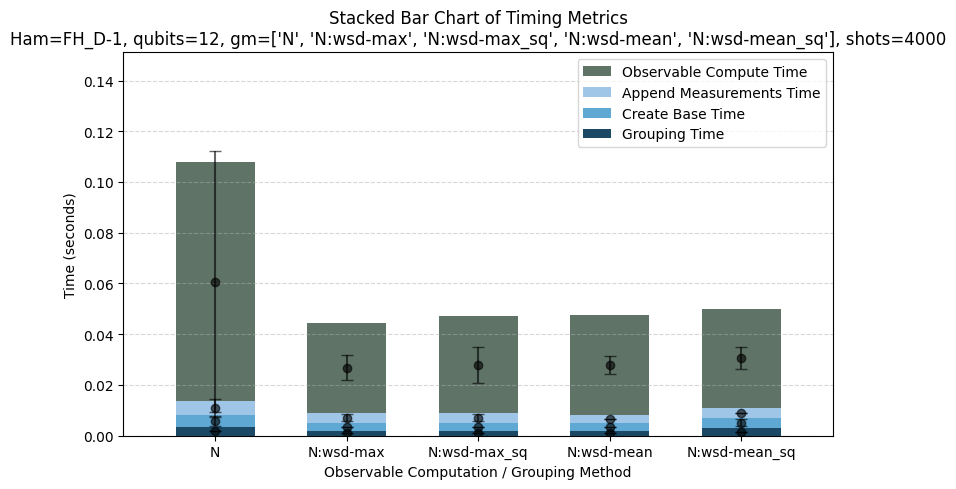

----final errors----
N: 0.360
N:wsd-max: 0.395
N:wsd-max_sq: 0.092
N:wsd-mean: 0.092
N:wsd-mean_sq: 0.196
----final means----
N: -0.232
N:wsd-max: -0.133
N:wsd-max_sq: 0.009
N:wsd-mean: 0.194
N:wsd-mean_sq: 0.222


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

group_method_list = [ "N", "N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    if distribute_shots is True:
        for wsd_method in wsd_methods:
            print(f'---wsd method: {wsd_method}---')
    
            init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots, wsd_method,
                                                                                         backend_id)

            # Generate the value anlysis plots
            std_error, mean = get_errors(
                        hamiltonian_name,
                        backend_id,
                        num_qubits,
                        group_method_label,
                        num_shots,
                        exact_energies,
                        computed_energies
                    )
            print('error:', std_error)
            print('mean:', mean)
        
        
            # Compute statistics for the collected metrics
            stats_result = compute_timing_stats(metrics_array)
            #print(stats_result)
            
            timing_datasets.append(stats_result)
            timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{wsd_method}" })
            final_errors[f"{group_method_label}-{wsd_method}"] = std_error
            final_means[f"{group_method_label}-{wsd_method}"] = mean
    else:
        print('---no weight shot distribution---')
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
        final_errors[f"{group_method_label}"] = std_error
        final_means[f"{group_method_label}"] = mean
        
        
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = ['N']
for wsd in wsd_methods:
    group_method_labels.append(f'N:wsd-{wsd}')
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [14]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[3]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}


... dataset_name = bh_graph-1D-grid-nonpbc-qubitnodes_Lx-6_U-10_enc-gray_d-4
... number of terms in Hamiltonian = 179



In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

group_method_list = [ "N", "N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    if distribute_shots is True:
        for wsd_method in wsd_methods:
            print(f'---wsd method: {wsd_method}---')
    
            init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots, wsd_method,
                                                                                         backend_id)

            # Generate the value anlysis plots
            std_error, mean = get_errors(
                        hamiltonian_name,
                        backend_id,
                        num_qubits,
                        group_method_label,
                        num_shots,
                        exact_energies,
                        computed_energies
                    )
            print('error:', std_error)
            print('mean:', mean)
        
        
            # Compute statistics for the collected metrics
            stats_result = compute_timing_stats(metrics_array)
            #print(stats_result)
            
            timing_datasets.append(stats_result)
            timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{wsd_method}" })
            final_errors[f"{group_method_label}-{wsd_method}"] = std_error
            final_means[f"{group_method_label}-{wsd_method}"] = mean
    else:
        print('---no weight shot distribution---')
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
        final_errors[f"{group_method_label}"] = std_error
        final_means[f"{group_method_label}"] = mean
        
        
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = ['N']
for wsd in wsd_methods:
    group_method_labels.append(f'N:wsd-{wsd}')
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

done

Perform Observable Computation for: condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 12
    number of terms in Hamiltonian = 179, number of groups created = 11

... Number of terms in Hamiltonian: 179
... Number of groups created: 11

... Pauli Term Groups:
---N----
---no weight shot distribution---

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 1.060431303760737
mean: -0.95197042057044
---N:wsd----
---wsd method: max---

.

In [ ]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[4]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

group_method_list = [ "N", "N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    if distribute_shots is True:
        for wsd_method in wsd_methods:
            print(f'---wsd method: {wsd_method}---')
    
            init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots, wsd_method,
                                                                                         backend_id)

            # Generate the value anlysis plots
            std_error, mean = get_errors(
                        hamiltonian_name,
                        backend_id,
                        num_qubits,
                        group_method_label,
                        num_shots,
                        exact_energies,
                        computed_energies
                    )
            print('error:', std_error)
            print('mean:', mean)
        
        
            # Compute statistics for the collected metrics
            stats_result = compute_timing_stats(metrics_array)
            #print(stats_result)
            
            timing_datasets.append(stats_result)
            timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{wsd_method}" })
            final_errors[f"{group_method_label}-{wsd_method}"] = std_error
            final_means[f"{group_method_label}-{wsd_method}"] = mean
    else:
        print('---no weight shot distribution---')
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
        final_errors[f"{group_method_label}"] = std_error
        final_means[f"{group_method_label}"] = mean
        
        
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = ['N']
for wsd in wsd_methods:
    group_method_labels.append(f'N:wsd-{wsd}')
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[5]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

group_method_list = [ "N", "N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    if distribute_shots is True:
        for wsd_method in wsd_methods:
            print(f'---wsd method: {wsd_method}---')
    
            init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots, wsd_method,
                                                                                         backend_id)

            # Generate the value anlysis plots
            std_error, mean = get_errors(
                        hamiltonian_name,
                        backend_id,
                        num_qubits,
                        group_method_label,
                        num_shots,
                        exact_energies,
                        computed_energies
                    )
            print('error:', std_error)
            print('mean:', mean)
        
        
            # Compute statistics for the collected metrics
            stats_result = compute_timing_stats(metrics_array)
            #print(stats_result)
            
            timing_datasets.append(stats_result)
            timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{wsd_method}" })
            final_errors[f"{group_method_label}-{wsd_method}"] = std_error
            final_means[f"{group_method_label}-{wsd_method}"] = mean
    else:
        print('---no weight shot distribution---')
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
        final_errors[f"{group_method_label}"] = std_error
        final_means[f"{group_method_label}"] = mean
        
        
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = ['N']
for wsd in wsd_methods:
    group_method_labels.append(f'N:wsd-{wsd}')
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[6]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

group_method_list = [ "N", "N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    if distribute_shots is True:
        for wsd_method in wsd_methods:
            print(f'---wsd method: {wsd_method}---')
    
            init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots, wsd_method,
                                                                                         backend_id)

            # Generate the value anlysis plots
            std_error, mean = get_errors(
                        hamiltonian_name,
                        backend_id,
                        num_qubits,
                        group_method_label,
                        num_shots,
                        exact_energies,
                        computed_energies
                    )
            print('error:', std_error)
            print('mean:', mean)
        
        
            # Compute statistics for the collected metrics
            stats_result = compute_timing_stats(metrics_array)
            #print(stats_result)
            
            timing_datasets.append(stats_result)
            timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{wsd_method}" })
            final_errors[f"{group_method_label}-{wsd_method}"] = std_error
            final_means[f"{group_method_label}-{wsd_method}"] = mean
    else:
        print('---no weight shot distribution---')
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
        final_errors[f"{group_method_label}"] = std_error
        final_means[f"{group_method_label}"] = mean
        
        
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = ['N']
for wsd in wsd_methods:
    group_method_labels.append(f'N:wsd-{wsd}')
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[7]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")


In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

num_k = num_qubits

group_method_list = [ "N", "N:wsd"]

timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

print("\n======================================================================================")
print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")    
print("")
print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
print(f"... Number of groups created: {len(pauli_term_groups)}")
print("")

print(f"... Pauli Term Groups:")

final_errors = {}
final_means = {}
for group_method_label in group_method_list:
    print(f'---{group_method_label}----')
    if group_method_label is not None and ":" in group_method_label:
        parts = group_method_label.split(":")
        group_method = parts[0]
        #last_part = parts[-1]
        distribute_shots = True
    else:
        group_method = group_method_label
        distribute_shots = False

    if distribute_shots is True:
        for wsd_method in wsd_methods:
            print(f'---wsd method: {wsd_method}---')
    
            init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots, wsd_method,
                                                                                         backend_id)

            # Generate the value anlysis plots
            std_error, mean = get_errors(
                        hamiltonian_name,
                        backend_id,
                        num_qubits,
                        group_method_label,
                        num_shots,
                        exact_energies,
                        computed_energies
                    )
            print('error:', std_error)
            print('mean:', mean)
        
        
            # Compute statistics for the collected metrics
            stats_result = compute_timing_stats(metrics_array)
            #print(stats_result)
            
            timing_datasets.append(stats_result)
            timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}-{wsd_method}" })
            final_errors[f"{group_method_label}-{wsd_method}"] = std_error
            final_means[f"{group_method_label}-{wsd_method}"] = mean
    else:
        print('---no weight shot distribution---')
        init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id)

        # Generate the value anlysis plots
        std_error, mean = get_errors(
                    hamiltonian_name,
                    backend_id,
                    num_qubits,
                    group_method_label,
                    num_shots,
                    exact_energies,
                    computed_energies
                )
        print('error:', std_error)
        print('mean:', mean)
        final_errors[f"{group_method_label}"] = std_error
        final_means[f"{group_method_label}"] = mean
        
        
        # Compute statistics for the collected metrics
        stats_result = compute_timing_stats(metrics_array)
        #print(stats_result)
        
        timing_datasets.append(stats_result)
        timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

group_method_labels = ['N']
for wsd in wsd_methods:
    group_method_labels.append(f'N:wsd-{wsd}')
    
# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )

print('----final errors----')
for key, value in final_errors.items():
    print(f"{key}: {value:.3f}")


print('----final means----')
for key, value in final_means.items():
    print(f"{key}: {value:.3f}")

In [ ]:
!pip install pandas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Define the experimental data
data = {
    "TFIM": {
        "N": 0.181,
        "N:wsd-max": 0.182,
        "N:wsd-max_sq": 0.183,
        "N:wsd-mean": 0.173,
        "N:wsd-mean_sq": 0.171
    },
    "Heis": {
        "N": 0.280,
        "N:wsd-max": 0.231,
        "N:wsd-max_sq": 0.239,
        "N:wsd-mean": 0.216,
        "N:wsd-mean_sq": 0.280
    },
    "FH": {
        "N": 0.517,
        "N:wsd-max": 0.443,
        "N:wsd-max_sq": 1.516,
        "N:wsd-mean": 0.436,
        "N:wsd-mean_sq": 0.504
    },
    "BH": {
        "N": 1.594,
        "N:wsd-max": 1.025,
        "N:wsd-max_sq": 4.960,
        "N:wsd-mean": 0.884,
        "N:wsd-mean_sq": 3.761
    },
    "H2": {
        "N": 0.252,
        "N:wsd-max": 0.132,
        "N:wsd-max_sq": 0.336,
        "N:wsd-mean": 0.095,
        "N:wsd-mean_sq": 0.205
    },
    "B2": {
        "N": 0.055,
        "N:wsd-max": 0.156,
        "N:wsd-max_sq": 0.164,
        "N:wsd-mean": 0.033,
        "N:wsd-mean_sq": 0.189
    },
    "NH": {
        "N": 0.145,
        "N:wsd-max": 0.261,
        "N:wsd-max_sq": 0.437,
        "N:wsd-mean": 0.067,
        "N:wsd-mean_sq": 0.395
    },
    "CH": {
        "N": 0.100,
        "N:wsd-max": 0.183,
        "N:wsd-max_sq": 0.173,
        "N:wsd-mean": 0.043,
        "N:wsd-mean_sq": 0.194
    }
}

# Step 2: Convert to DataFrame
df = pd.DataFrame(data).T

# Reorder columns as required
df = df[["N", "N:wsd-mean", "N:wsd-max", "N:wsd-mean_sq", "N:wsd-max_sq"]]

# Step 3: Prepare the bar chart data
df_plot = df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Error")
df_plot.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(14, 6))
models = df_plot["Model"].unique()
metrics = ["N", "N:wsd-mean", "N:wsd-max", "N:wsd-mean_sq", "N:wsd-max_sq"]
bar_width = 0.13
x = range(len(models))

# Updated group colors with a more saturated color replacing the yellow
group_colors = ['#8dd3c7', '#fb8072', '#FFB300', '#80b1d3', '#bebada']

for i, metric in enumerate(metrics):
    metric_values = df[metric].values
    plt.bar(
        [xi + i * bar_width for xi in x],
        metric_values,
        width=bar_width,
        label=metric,
        color=group_colors[i % len(group_colors)]
    )

plt.tick_params(axis='y', labelsize=24)
plt.xticks([xi + bar_width * (len(metrics) - 1) / 2 for xi in x], models, size=26)
plt.ylabel("Error", size=26)
plt.legend(fontsize=20)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig('exp2-a.pdf')
plt.show()
